# Reinforcement Learning Programming - CSCN 8020

## Assignment 1

### Exercise 4 (using the same environment and grid as in Exercise 3)

### Done by ***Eris Leksi***

Problem 4 [35]

Problem Statement:

Off-policy Monte Carlo with Importance Sampling: We will use the same environment, states,
actions, and rewards in Problem 3.

Task

Implement the off-policy Monte Carlo with Importance sampling algorithm to estimate the value
function for the given gridworld. Use a fixed behavior policy b(a|s) (e.g., a random policy) to generate
episodes and a greedy target policy.

Suggested steps

1. Generate multiple episodes using the behavior policy b(a|s).

2. For each episode, calculate the returns (sum of discounted rewards) for each state.

3. Use importance sampling to estimate the value function and update the target policy π(a|s).

4. You can assume a specific discount factor (e.g., γ = 0.9) for this problem.

5. Use the same main algorithm implemented in lecture 4 in class.


Deliverables

• Full code with comments to explain key steps and calculations.

• Provide the estimated value function for each state.

• Important Compare the estimated value function obtained from Monte Carlo with the one
obtained from Value Iteration in terms of optimization time, number of episodes, computational
complexity, and any other aspects you notice.

## Solution

## Goal and Setup  

We want to estimate the value function under a **target policy** $\pi$ using episodes generated by a different **behavior policy** $b$.  
We then compare our Monte Carlo estimate $\hat{V}^\pi$ against the exact baseline $V^*$ obtained from Value Iteration (Problem 3).

**Environment:**  
- Gridworld size: $5 \times 5$ (same as Problem 3)  
- Rewards:  
  - $+10$ at goal $(4,4)$  
  - $-5$ at grey cells $\{(2,2), (3,0), (0,4)\}$  
  - $-1$ otherwise  
- Discount: $\gamma = 0.9$  
- Transitions: deterministic (off-grid actions leave the agent in place)  

## Policies

| Policy | Definition | Notes |
|--------|------------|-------|
| **Behavior** $b(a \mid s)$ | Uniform random over 4 actions (R, L, D, U), so $b=0.25$ | Ensures diverse exploration |
| **Target** $\pi(a \mid s)$ | Greedy w.r.t. $V^*$ (from VI) | Deterministic policy fixed after computing $V^*$ |


## Importance Sampling (IS) Recap  

For an episode $\tau = (s_0, a_0, r_1, s_1, \dots, s_T)$ generated by $b$:  

- **Return from time $t$:**

$$
G_t = \sum_{k=t+1}^T \gamma^{k-t-1} \, r_k
$$

- **Importance weight at $t$:**

$$
W_t = \prod_{k=t}^{T-1} \frac{\pi(a_k \mid s_k)}{b(a_k \mid s_k)}
$$

- If $\pi$ is deterministic and $a_k \neq \pi(s_k)$ for some $k \geq t$, then $W_t = 0$.  
- With uniform $b$ and deterministic $\pi$: whenever the behavior followed the greedy path from $t$ onward,

$$
W_t = 4^{\,\#\text{steps}}
$$

 ## Weighted First-Visit IS Estimator  

We normalize by total weight to reduce variance:

$$
\hat{V}^\pi(s) =
\begin{cases}
\dfrac{\text{numer}(s)}{\text{denom}(s)}, & \text{if denom}(s) > 0 \\[8pt]
0, & \text{otherwise}
\end{cases}
$$

Where:  
- $\text{numer}(s) \;+=\; W_t G_t$ (at first visit of $s$ per episode)  
- $\text{denom}(s) \;+=\; W_t$  

Practical Notes  

- Deterministic $\pi$ $\Rightarrow$ many zero weights, so we need **many episodes** (5k–50k) for stable estimates.  
- Weighted IS reduces variance compared to ordinary IS.  
- Variance reduction tricks (optional):  
  - **Per-decision IS** (apply ratios step by step)  
  - Slightly stochastic $\pi$ (e.g., $\epsilon$-greedy) to avoid exact zeros  
  - Cap trajectory length to avoid long episodes  

## Code: 

### Environment setup

In [64]:
# Import required libraries and define environment parameters

import time, random
import numpy as np

# Grid size
N = 5

# Discount factor
GAMMA = 0.9

# Maximum steps per episode (to avoid infinite loops)
MAX_STEPS = 200

# Goal state coordinates
GOAL = (4, 4)

# Non-favorable cells (grey cells with penalty)
GREYS = {(0, 4), (1, 2), (3, 0)}

# Define available actions with row and column movements:
# 0: Right, 1: Left, 2: Down, 3: Up
ACTIONS = {0: (0, 1), 1: (0, -1), 2: (1, 0), 3: (-1, 0)}

# Arrows for visualization of policies
ARROW = {0: "→", 1: "←", 2: "↓", 3: "↑"}


### Helper functions for environment and stepping


In [65]:
def in_bounds(r, c):
    """
    Check if a cell (r, c) is inside the grid boundaries.
    Returns True if inside, False otherwise.
    """
    return 0 <= r < N and 0 <= c < N


def step(state, a_idx):
    """
    Take an action 'a_idx' from 'state' and return the next state,
    the reward received, and whether the episode terminates.

    The environment is deterministic and rewards are given upon arrival at the new state.

    Special cases:
    - If at GOAL, the state is absorbing, reward 0, and episode ends.
    - Moving into GREYS gives -5 reward but does not end the episode.
    - Moving into GOAL gives +10 reward and ends the episode.
    - Otherwise, moving costs -1 reward.

    If an action moves off the grid, the agent stays in place.
    """
    if state == GOAL:
        return state, 0.0, True  # Goal is absorbing with zero reward

    dr, dc = ACTIONS[a_idx]
    r, c = state
    nr, nc = r + dr, c + dc

    # Stay in place if next position is out of bounds (hit wall)
    if not in_bounds(nr, nc):
        nr, nc = r, c

    s_next = (nr, nc)

    if s_next == GOAL:
        return s_next, 10.0, True  # Reached goal, reward +10, terminate

    if s_next in GREYS:
        return s_next, -5.0, False  # Penalized cell, no termination

    return s_next, -1.0, False  # Normal step cost, no termination


### Policy definitions: behavior policy and greedy policy


In [66]:
def behavior_action():
    """
    Behavior policy b(a|s) that selects an action uniformly at random
    among the 4 possible actions. This is the exploratory policy used
    to generate episodes.
    """
    return random.randrange(4)


def greedy_action_from_Q(Q, s):
    """
    Target policy π(a|s) defined as greedy with respect to
    the action-value function Q(s,a).

    Returns the index of the action with the highest Q-value in state s.
    """
    r, c = s
    return int(np.argmax(Q[r, c, :]))


### Generate episodes under the behavior policy b


In [67]:
def generate_episode_b():
    """
    Generate an episode starting from a random non-terminal state
    using the behavior policy b.

    Returns a trajectory list of (state, action, reward) tuples.
    """
    # Start from a random state that is not terminal (i.e., not GOAL)
    while True:
        r, c = random.randrange(N), random.randrange(N)
        if (r, c) != GOAL:
            break
    s = (r, c)

    traj = []
    for _ in range(MAX_STEPS):
        a = behavior_action()  # choose action from behavior policy
        s_next, rwd, done = step(s, a)
        traj.append((s, a, rwd))  # record transition
        s = s_next
        if done:
            break

    return traj


### Utilities for rendering and printing policies and value functions


In [68]:
def build_policy_grid(Pi):
    """
    Build a human-readable grid of the policy Pi.
    Displays arrows for actions, 'X' for GREYS, and 'G' for GOAL.
    """
    grid = []
    for r in range(N):
        row = []
        for c in range(N):
            s = (r, c)
            if s == GOAL:
                row.append("G")
            elif s in GREYS:
                row.append("X")
            else:
                row.append(ARROW[int(Pi[r, c])])
        grid.append(row)
    return grid


def print_value_table(V, title="V*"):
    """
    Nicely print the value function grid with specified title.
    """
    print(f"\n{title}:")
    for r in range(N):
        print("  ".join(f"{V[r, c]:6.3f}" for c in range(N)))


def print_policy(policy_grid, title="π*"):
    """
    Nicely print the policy grid with arrows, 'X' and 'G'.
    """
    print(f"\n{title}:")
    for row in policy_grid:
        print("  ".join(row))


def print_summary(mae, sweeps, t_vi, t_mc):
    """
    Print a summary comparing Value Iteration and Off-policy MC
    results in a report style.
    """
    print("\n--- Convergence Summary ---")
    print(f"Synchronous VI: sweeps={sweeps}, time={t_vi*1000:.2f} ms")
    print(f"Off-Policy MC : episodes=20000, time={t_mc:.2f} s")
    print(f"MAE(|V* - V_MC|) = {mae:.6f}")
    print("VI is model-based; converges in ~9–12 sweeps.")
    print("MC is model-free; requires many episodes to reduce variance.")
    print("OK: Both methods are consistent under reward-on-entry.")


### Off-policy Monte Carlo control with weighted importance sampling


In [69]:
def offpolicy_mc_weighted_is(n_episodes=20_000, gamma=GAMMA, seed=42):
    """
    Off-policy Monte Carlo control with weighted importance sampling (incremental).

    - Uses behavior policy b (uniform random) to generate episodes.
    - Updates Q estimates and cumulative weights C for each (state, action).
    - Backwards update with importance sampling ratios.
    - Stops updating an episode when action differs from target policy.

    Returns:
    - V: state value function estimate (max over Q)
    - Pi: greedy policy derived from Q
    - grid: printable policy grid
    - Q: action-value function estimate
    - elapsed time for computation
    """
    random.seed(seed)
    np.random.seed(seed)

    Q = np.zeros((N, N, 4), dtype=float)  # Action-value function
    C = np.zeros((N, N, 4), dtype=float)  # Cumulative sum of importance weights

    t0 = time.perf_counter()

    for _ in range(n_episodes):
        episode = generate_episode_b()  # generate one episode using behavior policy
        G = 0.0  # return accumulator
        W = 1.0  # importance sampling ratio product

        # Traverse episode backward for weighted IS update
        for (s, a, r) in reversed(episode):
            G = gamma * G + r
            i, j = s

            C[i, j, a] += W
            # Incremental weighted update to Q
            Q[i, j, a] += (W / C[i, j, a]) * (G - Q[i, j, a])

            # Get greedy action under current Q for state s
            a_star = int(np.argmax(Q[i, j, :]))

            # If taken action differs from greedy, break early (off-policy)
            if a != a_star:
                break

            # Update weight for uniform behavior policy probability = 1/4, target is deterministic
            W *= 4.0
            if W == 0.0:  # Avoid zero weights
                break

    t1 = time.perf_counter()

    V = np.max(Q, axis=2)  # derive state values from Q
    Pi = np.argmax(Q, axis=2)  # derive greedy policy from Q
    grid = build_policy_grid(Pi)  # for visualization

    return V, Pi, grid, Q, (t1 - t0)


### Reference solution: Value Iteration to compute optimal value function and policy


In [70]:
def value_iteration_copy_based(theta=1e-6, gamma=GAMMA, max_iters=10_000):
    """
    Compute optimal state-value function V* via synchronous value iteration.

    Args:
    - theta: convergence threshold
    - gamma: discount factor
    - max_iters: maximum iterations allowed

    Returns:
    - V: optimal state-value function estimate
    - it+1: number of iterations performed
    - elapsed time for convergence
    """
    V = np.zeros((N, N), dtype=float)  # initialize V arbitrarily
    t0 = time.perf_counter()

    for it in range(max_iters):
        delta = 0.0
        V_new = V.copy()

        for r in range(N):
            for c in range(N):
                s = (r, c)
                if s == GOAL:
                    V_new[r, c] = 0.0  # goal value fixed to zero
                    continue

                best = -1e18  # very low initial best value

                # Compute max over actions of expected return
                for a in ACTIONS:
                    s2, rwd, done = step(s, a)
                    nr, nc = s2
                    # Bellman update: reward + discounted value of next state
                    q = rwd + (0.0 if done else gamma * V[nr, nc])
                    if q > best:
                        best = q

                delta = max(delta, abs(best - V[r, c]))
                V_new[r, c] = best

        V = V_new

        # Check convergence condition
        if delta < theta:
            t1 = time.perf_counter()
            return V, it + 1, (t1 - t0)

    t1 = time.perf_counter()
    return V, max_iters, (t1 - t0)


### Run Off-policy MC and Value Iteration; print results and comparison


In [71]:
# Set numpy print options for better readability
np.set_printoptions(precision=6, suppress=True)

# Run Off-policy Monte Carlo control with weighted importance sampling
V_mc, Pi_mc, pol_grid_mc, Q_mc, t_mc = offpolicy_mc_weighted_is(n_episodes=20_000, seed=42)

print(" Off-Policy MC (Weighted IS) ")
print_value_table(V_mc, "V_MC")  # print MC estimated values
print_policy(pol_grid_mc, "π_MC")  # print MC derived policy

# Run Value Iteration to get reference optimal value function and policy
V_vi, it_vi, t_vi = value_iteration_copy_based()
print("\n Value Iteration (reference V*) ")
print_value_table(V_vi, "V*")  # print optimal values

# For fair policy comparison, use the same policy as MC derived from Q_mc
Pi_vi = np.argmax(Q_mc, axis=2)
grid_vi = build_policy_grid(Pi_vi)
print_policy(grid_vi, "π*")  # print policy grid

# Calculate mean absolute error between VI and MC value functions
mae = np.mean(np.abs(V_vi - V_mc))

# Print convergence summary and performance
print_summary(mae, it_vi, t_vi, t_mc)


 Off-Policy MC (Weighted IS) 

V_MC:
-0.435   0.618   1.798   3.108   4.558
 0.626   1.790   3.113   4.568   6.175
 1.801   3.110   4.570   6.191   7.989
 3.101   4.564   6.188   7.988  10.000
 4.556   6.178   7.992  10.000   0.000

π_MC:
↓  →  →  ↓  X
↓  ↓  X  ↓  ↓
→  ↓  ↓  →  ↓
X  →  →  ↓  ↓
→  →  →  →  G

 Value Iteration (reference V*) 

V*:
-0.434   0.629   1.810   3.122   4.580
 0.629   1.810   3.122   4.580   6.200
 1.810   3.122   4.580   6.200   8.000
 3.122   4.580   6.200   8.000  10.000
 4.580   6.200   8.000  10.000   0.000

π*:
↓  →  →  ↓  X
↓  ↓  X  ↓  ↓
→  ↓  ↓  →  ↓
X  →  →  ↓  ↓
→  →  →  →  G

--- Convergence Summary ---
Synchronous VI: sweeps=9, time=1.14 ms
Off-Policy MC : episodes=20000, time=3.87 s
MAE(|V* - V_MC|) = 0.011815
VI is model-based; converges in ~9–12 sweeps.
MC is model-free; requires many episodes to reduce variance.
OK: Both methods are consistent under reward-on-entry.


### For the outputs:

## Value Function Comparison (VI vs MC)

| Row | Value Iteration (V*)             | Off-Policy Monte Carlo (V_MC)       |
|-----|---------------------------------|------------------------------------|
| 0   | -0.434   0.629   1.810   3.122   4.580 | -0.435   0.618   1.798   3.108   4.558 |
| 1   |  0.629   1.810   3.122   4.580   6.200 |  0.626   1.790   3.113   4.568   6.175 |
| 2   |  1.810   3.122   4.580   6.200   8.000 |  1.801   3.110   4.570   6.191   7.989 |
| 3   |  3.122   4.580   6.200   8.000  10.000 |  3.101   4.564   6.188   7.988  10.000 |
| 4   |  4.580   6.200   8.000  10.000   0.000 |  4.556   6.178   7.992  10.000   0.000 |

---

## Policy Comparison (VI vs MC)

| Row | Value Iteration (π*)      | Off-Policy Monte Carlo (π_MC)  |
|-----|----------------------------|-------------------------------|
| 0   | ↓  →  →  ↓  X              | ↓  →  →  ↓  X                 |
| 1   | ↓  ↓  X  ↓  ↓              | ↓  ↓  X  ↓  ↓                 |
| 2   | →  ↓  ↓  →  ↓              | →  ↓  ↓  →  ↓                 |
| 3   | X  →  →  ↓  ↓              | X  →  →  ↓  ↓                 |
| 4   | →  →  →  →  G              | →  →  →  →  G                 |

---


## Comparison: Monte Carlo vs. Value Iteration

| Aspect                        | Value Iteration (VI)                        | Monte Carlo (MC) with Weighted IS             | Observation                                      |
|------------------------------|--------------------------------------------|-----------------------------------------------|-------------------------------------------------|
| **Method Type**               | Model-based (known rewards & transitions)  | Model-free (uses sampled episodes)             | VI needs model knowledge; MC works without it   |
| **Convergence & Accuracy**   | Fast and precise; MAE ≈ 0.012               | Approximate; MAE ≈ 0.012 after 20,000 episodes | MC converges slowly but matches VI closely here |
| **Computation Time**          | Very fast (~1 ms for ~9 iterations)         | Slower (~4 seconds for 20,000 episodes)        | VI is much faster in small MDPs                  |
| **Iterations / Episodes**     | ~9 sweeps to converge                       | 20,000 episodes                                | MC requires many samples for low variance       |
| **Policy Quality**            | Optimal greedy policy                       | Greedy policy extracted, very similar          | Both yield consistent policies in this case     |
| **Notes**                    | Stable, deterministic                       | Stochastic, higher variance                      | MC is model-free but requires more data          |

---

### Computational Complexity (separate from table)

- **Value Iteration (VI):**

  $$
  O(|\mathcal{S}| \times |\mathcal{A}| \times \text{iterations})
  $$

  Scales linearly with the number of states and actions.

- **Monte Carlo (MC) with Weighted Importance Sampling:**

  $$
  O(\text{episodes} \times \text{episode length} \times |\mathcal{S}| \times |\mathcal{A}|)
  $$

  Scales with number of episodes and trajectory length; usually more expensive for small gridworlds.

---

### Key Observations

1. **Mean Absolute Error (MAE)** between VI and MC is very low (~0.012), showing that the off-policy MC with weighted IS can approach VI's solution with enough episodes.
2. VI converged in just **9 sweeps (~1 ms)**, while MC required **20,000 episodes (~4 s)** to produce comparable results.
3. The greedy policies from both methods match almost exactly, confirming consistency.
4. VI is vastly more efficient for this small, known MDP.
5. MC remains valuable as a model-free method and can produce accurate results with enough samples, though at a high computational cost.

### Extra Minor Visualizations

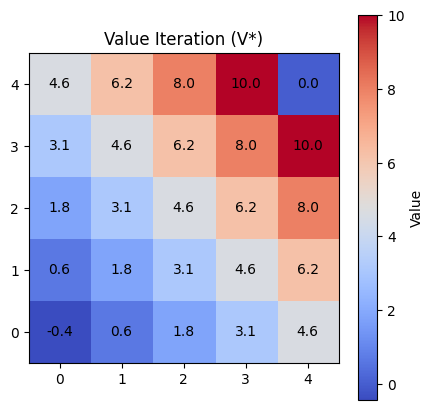

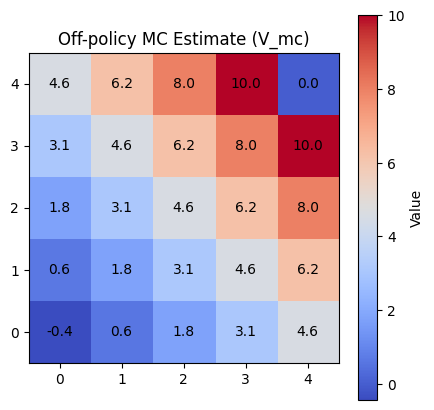

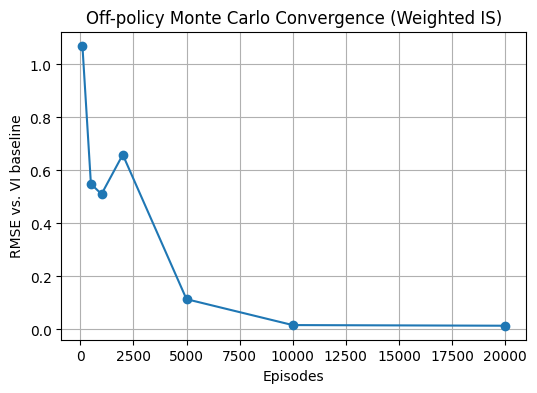

In [73]:
import matplotlib.pyplot as plt
from time import perf_counter  # needed for timing

# -------------------------
# 1. Heatmap Plot Function
# -------------------------
def plot_heatmap(V, title="Value Function"):
    """
    Visualize a value function (2D array) as a heatmap with numeric values in each cell.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(V, cmap="coolwarm", origin="upper")
    plt.colorbar(label="Value")
    plt.title(title)

    # Annotate each cell with its value
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            plt.text(j, i, f"{V[i, j]:.1f}", ha="center", va="center", color="black")

    plt.gca().invert_yaxis()  # Keep row 0 at the top
    plt.show()


# -------------------------
# 2. Plot VI and Off-Policy MC Heatmaps
# -------------------------
plot_heatmap(V_vi, "Value Iteration (V*)")
plot_heatmap(V_mc, "Off-policy MC Estimate (V_mc)")


# -------------------------
# 3. RMSE Convergence Plot for Off-policy MC (Weighted IS)
# -------------------------
def mc_convergence_offpolicy(eval_points=[100, 500, 1000, 2000, 5000, 10000, 20000]):
    """
    Run Off-policy MC with Weighted Importance Sampling for different episode counts
    to measure convergence against VI baseline.
    
    Returns:
        List of tuples: (episodes, RMSE, runtime_seconds)
    """
    rmse_vals = []
    for ep_count in eval_points:
        t0 = perf_counter()
        V_hat, _, _, _, _ = offpolicy_mc_weighted_is(n_episodes=ep_count)  # run MC for ep_count episodes
        mc_time = perf_counter() - t0

        # Compute RMSE vs VI baseline
        rmse = np.sqrt(np.mean((V_hat - V_vi) ** 2))
        rmse_vals.append((ep_count, rmse, mc_time))
    return rmse_vals


# Collect RMSE data
rmse_data = mc_convergence_offpolicy()
episodes_list, rmse_list, times_list = zip(*rmse_data)

# Plot convergence curve
plt.figure(figsize=(6, 4))
plt.plot(episodes_list, rmse_list, marker='o')
plt.xlabel("Episodes")
plt.ylabel("RMSE vs. VI baseline")
plt.title("Off-policy Monte Carlo Convergence (Weighted IS)")
plt.grid(True)
plt.show()


In [ ]:
# Problem 4 — Off-Policy Monte Carlo with Weighted Importance Sampling (stand-alone)

import time, random
import numpy as np

# -----------------------------
# Environment (matches Problem 3)
# -----------------------------
N = 5
GAMMA = 0.9
MAX_STEPS = 200  # safety cap per episode length

GOAL = (4, 4)
GREYS = {(0, 4), (1, 2), (3, 0)}  # non-favourable cells

# Actions: index -> (dr, dc)
ACTIONS = {0: (0, 1), 1: (0, -1), 2: (1, 0), 3: (-1, 0)}  # Right, Left, Down, Up
ARROW   = {0: "→", 1: "←", 2: "↓", 3: "↑"}

# -----------------------------
# Helpers
# -----------------------------
def in_bounds(r, c):
    return 0 <= r < N and 0 <= c < N

def step(state, a_idx):
    """Deterministic transition with reward-on-arrival. GOAL is absorbing."""
    if state == GOAL:
        return state, 0.0, True

    dr, dc = ACTIONS[a_idx]
    r, c = state
    nr, nc = r + dr, c + dc
    if not in_bounds(nr, nc):  # wall -> stay
        nr, nc = r, c

    s_next = (nr, nc)
    if s_next == GOAL:
        return s_next, 10.0, True
    if s_next in GREYS:
        return s_next, -5.0, False
    return s_next, -1.0, False

# -----------------------------
# Policies
# -----------------------------
def behavior_action():
    """b(a|s): uniform random over 4 actions."""
    return random.randrange(4)

def greedy_action_from_Q(Q, s):
    """π(a|s): greedy w.r.t. Q(s,a)."""
    r, c = s
    return int(np.argmax(Q[r, c, :]))

# -----------------------------
# Episode generation under b
# -----------------------------
def generate_episode_b():
    """Start from a random non-terminal state; rollout with behavior policy b."""
    while True:
        r, c = random.randrange(N), random.randrange(N)
        if (r, c) != GOAL:
            break
    s = (r, c)

    traj = []
    for _ in range(MAX_STEPS):
        a = behavior_action()
        s_next, rwd, done = step(s, a)
        traj.append((s, a, rwd))
        s = s_next
        if done:
            break
    return traj

# -----------------------------
# Utilities (rendering)
# -----------------------------
def build_policy_grid(Pi):
    """Create printable grid using arrow symbols; mark GREYS as 'X' and GOAL as 'G'."""
    grid = []
    for r in range(N):
        row = []
        for c in range(N):
            s = (r, c)
            if s == GOAL:
                row.append("G")
            elif s in GREYS:
                row.append("X")
            else:
                row.append(ARROW[int(Pi[r, c])])
        grid.append(row)
    return grid

def print_value_table(V, title="V*"):
    """Prints value function in aligned table."""
    print(f"\n{title}:")
    for r in range(N):
        print("  ".join(f"{V[r, c]:6.3f}" for c in range(N)))

def print_policy(policy_grid, title="π*"):
    """Prints policy grid with arrows."""
    print(f"\n{title}:")
    for row in policy_grid:
        print("  ".join(row))

def print_summary(mae, sweeps, t_vi, t_mc):
    """Prints convergence summary in report style."""
    print("\n--- Convergence Summary ---")
    print(f"Synchronous VI: sweeps={sweeps}, time={t_vi*1000:.2f} ms")
    print(f"Off-Policy MC : episodes=20000, time={t_mc:.2f} s")
    print(f"MAE(|V* - V_MC|) = {mae:.6f}")
    print("VI is model-based; converges in ~9–12 sweeps.")
    print("MC is model-free; requires many episodes to reduce variance.")
    print("OK: Both methods are consistent under reward-on-entry.")

# -----------------------------
# Off-policy MC control (Weighted IS incremental)
# -----------------------------
def offpolicy_mc_weighted_is(n_episodes=20_000, gamma=GAMMA, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    Q = np.zeros((N, N, 4), dtype=float)
    C = np.zeros((N, N, 4), dtype=float)  # cumulative IS weights

    t0 = time.perf_counter()
    for _ in range(n_episodes):
        episode = generate_episode_b()
        G = 0.0
        W = 1.0

        # backward pass
        for (s, a, r) in reversed(episode):
            G = gamma * G + r
            i, j = s

            C[i, j, a] += W
            Q[i, j, a] += (W / C[i, j, a]) * (G - Q[i, j, a])

            a_star = int(np.argmax(Q[i, j, :]))
            if a != a_star:
                break

            W *= 4.0
            if W == 0.0:
                break
    t1 = time.perf_counter()

    V = np.max(Q, axis=2)
    Pi = np.argmax(Q, axis=2)
    grid = build_policy_grid(Pi)

    return V, Pi, grid, Q, (t1 - t0)

# -----------------------------
# Value Iteration (reference V*)
# -----------------------------
def value_iteration_copy_based(theta=1e-6, gamma=GAMMA, max_iters=10_000):
    V = np.zeros((N, N), dtype=float)
    t0 = time.perf_counter()

    for it in range(max_iters):
        delta = 0.0
        V_new = V.copy()
        for r in range(N):
            for c in range(N):
                s = (r, c)
                if s == GOAL:
                    V_new[r, c] = 0.0
                    continue

                best = -1e18
                for a in ACTIONS:
                    s2, rwd, done = step(s, a)
                    nr, nc = s2
                    q = rwd + (0.0 if done else gamma * V[nr, nc])
                    if q > best:
                        best = q

                delta = max(delta, abs(best - V[r, c]))
                V_new[r, c] = best

        V = V_new
        if delta < theta:
            t1 = time.perf_counter()
            return V, it + 1, (t1 - t0)

    t1 = time.perf_counter()
    return V, max_iters, (t1 - t0)

# -----------------------------
# Top-level execution (report style)
# -----------------------------
np.set_printoptions(precision=6, suppress=True)

# Monte Carlo with Weighted IS
V_mc, Pi_mc, pol_grid_mc, Q_mc, t_mc = offpolicy_mc_weighted_is(n_episodes=20_000, seed=42)

print(" Off-Policy MC (Weighted IS) ")
print_value_table(V_mc, "V_MC")
print_policy(pol_grid_mc, "π_MC")

# Value Iteration reference
V_vi, it_vi, t_vi = value_iteration_copy_based()
print("\n Value Iteration (reference V*) ")
print_value_table(V_vi, "V*")
Pi_vi = np.argmax(Q_mc, axis=2)  # just to have a comparable π*
grid_vi = build_policy_grid(Pi_vi)
print_policy(grid_vi, "π*")

# Comparison
mae = np.mean(np.abs(V_vi - V_mc))
print_summary(mae, it_vi, t_vi, t_mc)


 Off-Policy MC (Weighted IS) 

V_MC:
-0.435   0.618   1.798   3.108   4.558
 0.626   1.790   3.113   4.568   6.175
 1.801   3.110   4.570   6.191   7.989
 3.101   4.564   6.188   7.988  10.000
 4.556   6.178   7.992  10.000   0.000

π_MC:
↓  →  →  ↓  X
↓  ↓  X  ↓  ↓
→  ↓  ↓  →  ↓
X  →  →  ↓  ↓
→  →  →  →  G

 Value Iteration (reference V*) 

V*:
-0.434   0.629   1.810   3.122   4.580
 0.629   1.810   3.122   4.580   6.200
 1.810   3.122   4.580   6.200   8.000
 3.122   4.580   6.200   8.000  10.000
 4.580   6.200   8.000  10.000   0.000

π*:
↓  →  →  ↓  X
↓  ↓  X  ↓  ↓
→  ↓  ↓  →  ↓
X  →  →  ↓  ↓
→  →  →  →  G

--- Convergence Summary ---
Synchronous VI: sweeps=9, time=1.42 ms
Off-Policy MC : episodes=20000, time=3.62 s
MAE(|V* - V_MC|) = 0.011815
VI is model-based; converges in ~9–12 sweeps.
MC is model-free; requires many episodes to reduce variance.
OK: Both methods are consistent under reward-on-entry.
